In [1]:
!pip install dm-sonnet==2.0 tensorflow==2.10 numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existi

In [1]:

import os
import tarfile
import numpy as np
# Patch np.bool deprecation
if not hasattr(np, 'bool'):
    np.bool = bool

import collections
# Patch for Python 3.10+ compatibility
if not hasattr(collections, 'Sequence'):
    from collections.abc import Sequence
    collections.Sequence = Sequence


import tensorflow as tf
import sonnet as snt
import matplotlib.pyplot as plt
from six.moves import cPickle
from six.moves import urllib

<ipython-input-1-fcc5225c0934>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, 'bool'):


### Loading and preparing CIFAR10 Datasets

In [2]:

# Data path for CIFAR-10 dataset
data_path = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
local_data_dir = "./cifar-10-data"
os.makedirs(local_data_dir, exist_ok=True)

# Download and extract CIFAR-10 data
url = urllib.request.urlopen(data_path)
archive = tarfile.open(fileobj=url, mode='r|gz')  # Read .tar.gz stream
archive.extractall(local_data_dir)
url.close()
archive.close()
print(f"Extracted data files to {local_data_dir}")

Extracted data files to ./cifar-10-data


In [3]:
# Helper functions
def unpickle(filename):
    """Unpickle the data from the CIFAR-10 dataset."""
    with open(filename, 'rb') as fo:
        return cPickle.load(fo, encoding='latin1')

def reshape_flattened_image_batch(flat_image_batch):
    """Reshape images from NCHW to NHWC."""
    return flat_image_batch.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])

def combine_batches(batch_list):
    """Combine multiple batches into a single dataset."""
    images = np.vstack([reshape_flattened_image_batch(batch['data']) for batch in batch_list])
    labels = np.hstack([batch['labels'] for batch in batch_list])
    return {'images': images, 'labels': labels}

# Load training, validation, and test data
train_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, f'cifar-10-batches-py/data_batch_{i}'))
    for i in range(1, 5)
])

valid_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/data_batch_5'))
])

test_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/test_batch'))
])

In [4]:
def cast_and_normalize_images(data_dict):
    """Normalize images to range [-0.5, 0.5]."""
    images = data_dict['images']
    data_dict['images'] = (images.astype(np.float32) / 255.0) - 0.5
    return data_dict

train_data_dict = cast_and_normalize_images(train_data_dict)
valid_data_dict = cast_and_normalize_images(valid_data_dict)
test_data_dict = cast_and_normalize_images(test_data_dict)

#### Building Model Architecture(Encoder, decoder, VQ-VAE)

In [5]:
# Residual stack implementation
def residual_stack(h, num_hiddens, num_residual_layers, num_residual_hiddens):
    """Apply a stack of residual layers."""
    for i in range(num_residual_layers):
        h_i = tf.nn.relu(h)
        h_i = snt.Conv2D(num_residual_hiddens, kernel_shape=3, stride=1, name=f"res3x3_{i}")(h_i)
        h_i = tf.nn.relu(h_i)
        h_i = snt.Conv2D(num_hiddens, kernel_shape=1, stride=1, name=f"res1x1_{i}")(h_i)
        h += h_i
    return tf.nn.relu(h)

# Encoder module
class Encoder(snt.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, name='encoder'):
        super().__init__(name=name)
        self.conv1 = snt.Conv2D(num_hiddens // 2, kernel_shape=4, stride=2, name="enc_1")
        self.conv2 = snt.Conv2D(num_hiddens, kernel_shape=4, stride=2, name="enc_2")
        self.conv3 = snt.Conv2D(num_hiddens, kernel_shape=3, stride=1, name="enc_3")
        self.residual_stack = residual_stack

    def __call__(self, x):
        h = tf.nn.relu(self.conv1(x))
        h = tf.nn.relu(self.conv2(h))
        h = self.conv3(h)
        h = self.residual_stack(h, num_hiddens, num_residual_layers, num_residual_hiddens)
        return h

# Decoder module
class Decoder(snt.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, name='decoder'):
        super().__init__(name=name)
        self.conv1 = snt.Conv2D(num_hiddens, kernel_shape=3, stride=1, name="dec_1")
        self.conv2 = snt.Conv2DTranspose(num_hiddens // 2, kernel_shape=4, stride=2, name="dec_2")
        self.conv3 = snt.Conv2DTranspose(3, kernel_shape=4, stride=2, name="dec_3")
        self.residual_stack = residual_stack

    def __call__(self, x):
        h = self.conv1(x)
        h = self.residual_stack(h, num_hiddens, num_residual_layers, num_residual_hiddens)
        h = tf.nn.relu(self.conv2(h))
        x_recon = self.conv3(h)
        return x_recon


In [6]:
# Hyperparameters
batch_size = 32
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.25
learning_rate = 3e-4

# Model components
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)

pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim, kernel_shape=1, stride=1, name="to_vq")
vq_vae = snt.nets.VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)

# Input data placeholder
x = tf.keras.Input(shape=(32, 32, 3))

# Forward pass
z = pre_vq_conv1(encoder(x))
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
loss = tf.reduce_mean((x_recon - x)**2) + vq_output_train["loss"]

# Optimizer and training step
optimizer = tf.keras.optimizers.Adam(learning_rate)
train_step = tf.function(lambda x: optimizer.minimize(loss, var_list=encoder.trainable_variables + decoder.trainable_variables + vq_vae.trainable_variables))

### Model Training

In [7]:
# Import necessary libraries
import time

# Metrics to track
train_losses = []
valid_losses = []

# Training and validation loops
num_epochs = 10  # You can set this based on your computational resources
steps_per_epoch = len(train_data_dict['images']) // batch_size
validation_steps = len(valid_data_dict['images']) // batch_size

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_start_time = time.time()

    # Training phase
    train_loss = 0
    for step in range(steps_per_epoch):
        # Sample a batch of training data
        start_idx = step * batch_size
        end_idx = start_idx + batch_size
        batch_images = train_data_dict['images'][start_idx:end_idx]

        # Forward and backward pass
        with tf.GradientTape() as tape:
            z = pre_vq_conv1(encoder(batch_images))
            vq_output_train = vq_vae(z, is_training=True)
            x_recon = decoder(vq_output_train["quantize"])
            recon_error = tf.reduce_mean((x_recon - batch_images) ** 2)
            loss = recon_error + vq_output_train["loss"]

        gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables + vq_vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables + vq_vae.trainable_variables))

        train_loss += loss.numpy()

    # Average training loss
    train_loss /= steps_per_epoch
    train_losses.append(train_loss)

    # Validation phase
    valid_loss = 0
    for step in range(validation_steps):
        # Sample a batch of validation data
        start_idx = step * batch_size
        end_idx = start_idx + batch_size
        batch_images = valid_data_dict['images'][start_idx:end_idx]

        # Forward pass
        z = pre_vq_conv1(encoder(batch_images))
        vq_output_eval = vq_vae(z, is_training=False)
        x_recon = decoder(vq_output_eval["quantize"])
        recon_error = tf.reduce_mean((x_recon - batch_images) ** 2)
        loss = recon_error + vq_output_eval["loss"]

        valid_loss += loss.numpy()

    # Average validation loss
    valid_loss /= validation_steps
    valid_losses.append(valid_loss)

    epoch_end_time = time.time()
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss:.4f}, Validation Loss = {valid_loss:.4f}, Time = {epoch_end_time - epoch_start_time:.2f}s")


Epoch 1/10
Epoch 1: Training Loss = 0.0452, Validation Loss = 0.0248, Time = 439.96s
Epoch 2/10
Epoch 2: Training Loss = 0.0226, Validation Loss = 0.0221, Time = 431.49s
Epoch 3/10
Epoch 3: Training Loss = 0.0216, Validation Loss = 0.0205, Time = 429.11s
Epoch 4/10
Epoch 4: Training Loss = 0.0199, Validation Loss = 0.0192, Time = 425.61s
Epoch 5/10
Epoch 5: Training Loss = 0.0185, Validation Loss = 0.0190, Time = 439.78s
Epoch 6/10
Epoch 6: Training Loss = 0.0183, Validation Loss = 0.0185, Time = 432.21s
Epoch 7/10
Epoch 7: Training Loss = 0.0179, Validation Loss = 0.0182, Time = 423.74s
Epoch 8/10
Epoch 8: Training Loss = 0.0175, Validation Loss = 0.0179, Time = 423.29s
Epoch 9/10
Epoch 9: Training Loss = 0.0171, Validation Loss = 0.0171, Time = 420.69s
Epoch 10/10
Epoch 10: Training Loss = 0.0168, Validation Loss = 0.0165, Time = 422.19s


In [14]:
# Save each model individually after training
# Save weights


# Set the directory to '/content/checkpoints'
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure directory exists

# Create the Checkpoint object
checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder, vq_vae=vq_vae)

# Create a CheckpointManager to manage saving
checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=3)

# Save the checkpoint
save_path = checkpoint_manager.save()
print(f"Checkpoint saved at: {save_path}")





Checkpoint saved at: /content/checkpoints/ckpt-1


### Results

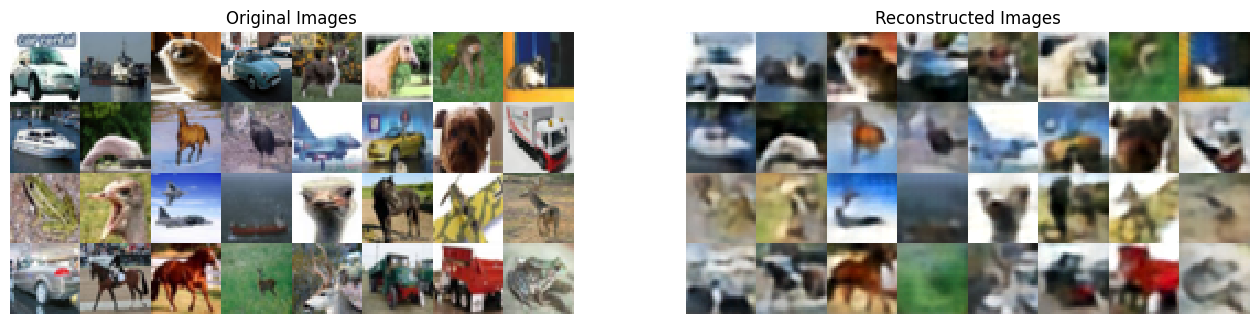

In [8]:
# Visualization of reconstructed images
def convert_batch_to_image_grid(image_batch):
    """Convert batch of images into a grid for visualization."""
    reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
                .transpose(0, 2, 1, 3, 4)
                .reshape(4 * 32, 8 * 32, 3))
    return reshaped + 0.5

# Select a batch from validation data
val_images = valid_data_dict['images'][:batch_size]
z = pre_vq_conv1(encoder(val_images))
vq_output_eval = vq_vae(z, is_training=False)
val_reconstructions = decoder(vq_output_eval["quantize"]).numpy()

# Plot original and reconstructed images
plt.figure(figsize=(16, 8))

# Original images
plt.subplot(1, 2, 1)
plt.imshow(convert_batch_to_image_grid(val_images), interpolation='nearest')
plt.title("Original Images")
plt.axis("off")

# Reconstructed images
plt.subplot(1, 2, 2)
plt.imshow(convert_batch_to_image_grid(val_reconstructions), interpolation='nearest')
plt.title("Reconstructed Images")
plt.axis("off")

plt.show()

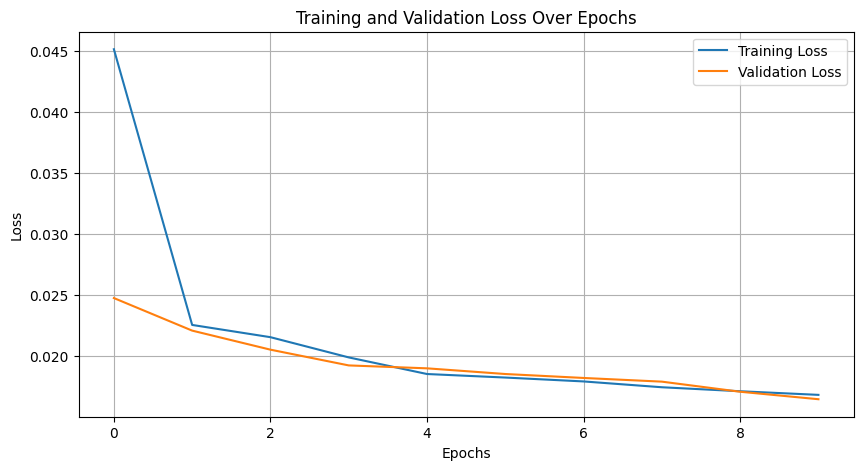

In [9]:
# Plot Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
from google.colab.files import download

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


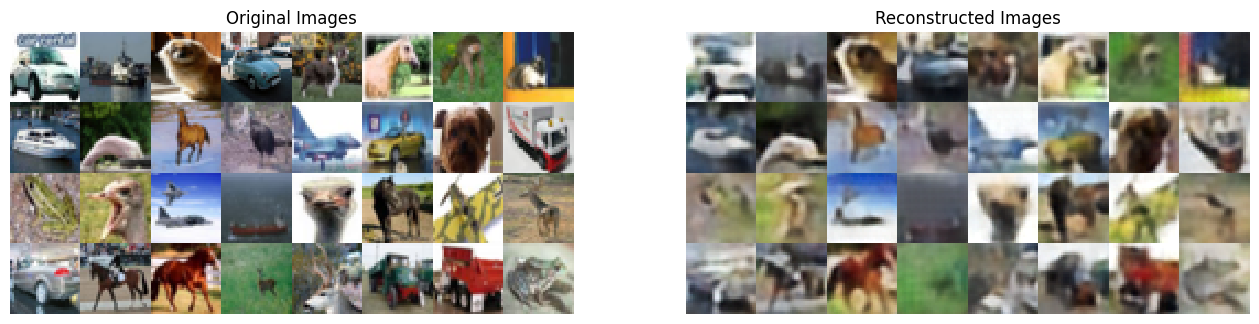

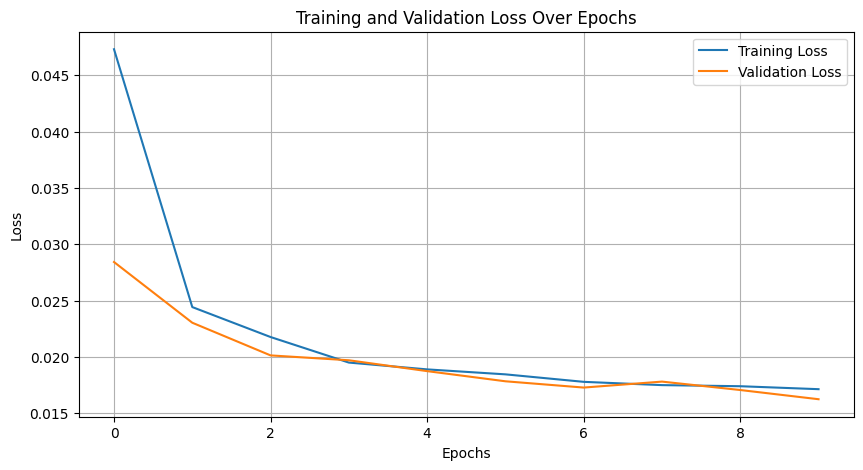

In [ ]:
# Plot original and reconstructed images
plt.figure(figsize=(16, 8))

# Original images
plt.subplot(1, 2, 1)
plt.imshow(convert_batch_to_image_grid(val_images), interpolation='nearest')
plt.title("Original Images")
plt.axis("off")

# Reconstructed images
plt.subplot(1, 2, 2)
plt.imshow(convert_batch_to_image_grid(val_reconstructions), interpolation='nearest')
plt.title("Reconstructed Images")
plt.axis("off")
plt.savefig('/content/drive/My Drive/original_and_reconstructed.png', dpi=300)
plt.show()

# Plot Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/My Drive/loss_vs_epochs.png', dpi=300)
plt.show()

In [ ]:
download('/content/drive/My Drive/original_and_reconstructed.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
download('/content/drive/My Drive/loss_vs_epochs.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>